In [ ]:
!pip install parameter-sherpa pandas numpy

In [288]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import sherpa
%display typeset

from __future__ import print_function
from ipywidgets import *
import ipywidgets as widgets
%precision %.3f

'%.3f'

In [297]:
# População de QUEBEC e ONTÁRIO
CA_POP = 14810000

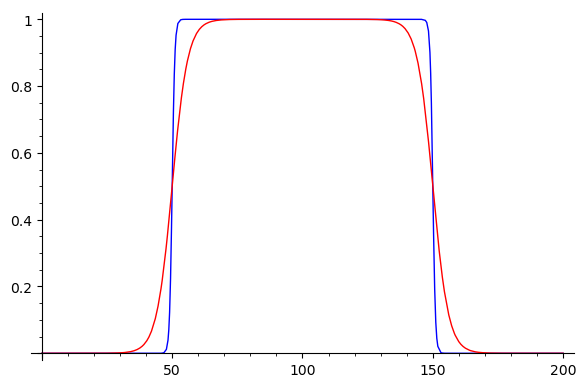

In [269]:
# A modelagem da quarentena pode ser feita da seguinte maneira:
eq = ((1 + np.tanh(x - 50)) / 2) * ((1 - np.tanh(x - 150)) / 2)
a = plot(eq, (x,0,200))

# Ou suavizando mais a curva:
eq = ((1 + np.tanh((x - 50)/6)) / 2) * ((1 - np.tanh((x - 150)/6)) / 2)
b = plot(eq, (x,0,200), color="red")

show(a+b)

In [263]:
# Função do modelo, o número de casos diários é phi*I e o número de mortes diário é mu*H
def model(t, y, params):
    S, E, I, A, H, R = y
    chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params
    lamb = beta * (I + A)
    
    # Para calcular o modelo mais rapidamente foi usado apenas um if:
    if (t < q or t > q + r):
        chi = 0
        
    # Turns on Quarantine on day q and off on day q+r
    #chi *= ((1 + np.tanh((t - q)/2)) / 2) * ((1 - np.tanh((t - (q+r))/2)) / 2)
    
    return [
        -lamb * ((1 - chi) * S),                   # 0 dS/dt
        lamb * ((1 - chi) * S) - alpha * E,        # 1 dE/dt
        (1 - p) * alpha * E - delta * I - phi * I, # 2 dI/dt
        p * alpha * E - gamma * A,                 # 3 dA/dt
        phi * I - (rho + mu) * H,                  # 4 dH/dt
        delta * I + rho * H + gamma * A,           # 5 dR/dt
    ]

def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

O = ode_solver()
O.function = model
O.algorithm = 'rk4'
inits = [.99, 0, 0, 1e-5, 0, 0]

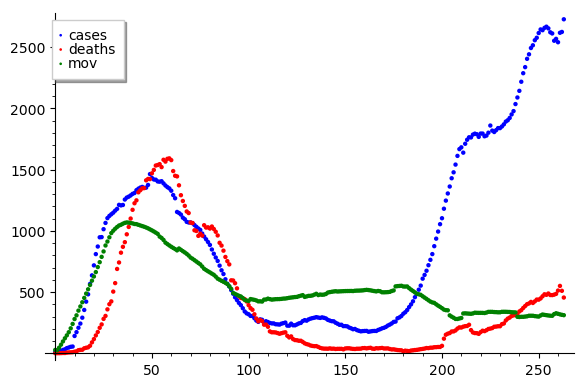

In [245]:
# Lê o arquivo com os dados, no caso foi usado os dados diários de casos, morte e movimentação
dfCA = pd.read_pickle("data.pkl")
LEN = len(dfCA)
a = list_plot(dfCA["cases"],     color='blue',  legend_label="cases")
b = list_plot(dfCA["deaths"]*10, color='red',   legend_label="deaths")
c = list_plot(dfCA["mov"]*20,    color='green', legend_label="mov")
show(a+b+c)

In [320]:
# Mostra o resultado com os parâmetros em um dicionário
def plot_results(result):
    pars = [result[n] for n in PARAM]
    phi = result['phi']
    mu = result['mu']
    t0 = result['t0']
    O.ode_solve([0, LEN+t0], inits, num_points=LEN+t0, params=pars)
    sim = get_sim_array(O.solution) * CA_POP
    
    H = phi*sim[:,2]
    M = mu*sim[:,4]
    i_err = int(sum((dfCA.cases-H[t0:LEN+t0])**2))
    h_err = int(sum((dfCA.deaths-M[t0:LEN+t0])**2))
    
    h   = list_plot(H,color='red',legend_label='new cases, SEQ: '+str(i_err), plotjoined=True)
    m   = list_plot(M,color='purple', legend_label='new deaths SEQ: '+str(h_err), plotjoined=True)
    cc  = list_plot(list(zip(range(t0,LEN+t0),dfCA.cases)), color='black',legend_label='cases (obs)')
    cd  = list_plot(list(zip(range(t0,LEN+t0),dfCA.deaths)), color='orange',legend_label='deaths(obs)')
    show(h + cc)
    #m  = list_plot(list(zip(range(t0,LEN+t0),dfCA.mov*20)), color='black',legend_label='mov')
    #show(i + cc + m)

In [220]:
def i_func(alpha, beta, chi, delta, gamma, mu, p, phi, q, r, rho, t0):
    resu = {
        'alpha': alpha,
        'beta':  beta,
        'chi':   chi,
        'delta': delta,
        'gamma': gamma,
        'mu':    mu,
        'p':     p,
        'phi':   phi,
        'q':     q,
        'r':     r,
        'rho':   rho,
        't0':    t0}
    plot_results(resu)

In [328]:
# Controle interativo
interact(i_func, 
         alpha = FloatSlider(value=0.30, min=0.0, max=1.0, step=0.01,  continuous_update=False), 
         beta  = FloatSlider(value=0.55,  min=0.0, max=1.0, step=0.01,  continuous_update=False), 
         chi   = FloatSlider(value=0.89,  min=0.0, max=1.0, step=0.01,  continuous_update=False), 
         delta = FloatSlider(value=0.04, min=0.0, max=0.05,step=0.0001,continuous_update=False),  
         gamma = FloatSlider(value=0.08, min=0.0, max=0.1, step=0.001, continuous_update=False), 
         mu    = FloatSlider(value=0.12, min=0.0, max=1.0, step=0.01,  continuous_update=False), 
         p     = FloatSlider(value=0.90, min=0.0, max=1.0, step=0.01,  continuous_update=False), 
         phi   = FloatSlider(value=0.007,min=0.0, max=0.04,step=0.0001,continuous_update=False), 
         q     = IntSlider  (value=42,   min=0,   max=100, continuous_update=False),
         r     = IntSlider  (value=145,  min=50,   max=250,continuous_update=False),
         rho   = FloatSlider(value=1.7,  min=0.0, max=2.0, step=0.01, continuous_update=False), 
         t0    = IntSlider  (value=16,   min=0,   max=100, continuous_update=False));

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='alpha', max=1.0, step=0.01)…

In [327]:
# Apriximar nos arredores do valor anterior
PARAM = ['chi', 'phi', 'beta', 'rho', 'delta', 'gamma', 'alpha', 'mu', 'p', 'q', 'r']
parameters = [
    sherpa.Continuous(name='alpha',range=[0.20,0.30]),
    sherpa.Continuous(name='beta' ,range=[0.50,0.60]),
    sherpa.Continuous(name='chi'  ,range=[0.8,0.999]),
    sherpa.Continuous(name='delta',range=[0.03,0.05]),
    sherpa.Continuous(name='gamma',range=[0.06,0.09]),
    sherpa.Continuous(name='mu'   ,range=[0.10,0.13]),
    sherpa.Continuous(name='p'    ,range=[0.80,1.0]),
    sherpa.Continuous(name='phi'  ,range=[0.001,0.01]),
    sherpa.Discrete  (name='q'    ,range=[35,45]),
    sherpa.Discrete  (name='r'    ,range=[140,160]),
    sherpa.Continuous(name='rho'  ,range=[0.0,2.0]),
    sherpa.Discrete  (name='t0'   ,range=[10,20]),
]

TRIALS = 2000
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=TRIALS)

study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

trial = study.get_suggestion()
print(trial.parameters)

{'alpha': 0.2346694631650155, 'beta': 0.5784971290467186, 'chi': 0.9118272708649178, 'delta': 0.04691477465966796, 'gamma': 0.08325528725228962, 'mu': 0.11500910359337942, 'p': 0.9952901992863877, 'phi': 0.004971266132518145, 'q': 41, 'r': 149, 'rho': 1.8482085507802886, 't0': 16}


{'Trial-ID': 1682, 'Iteration': 1, 'alpha': 0.2283633568260642, 'beta': 0.5822849023764461, 'chi': 0.902760967076326, 'delta': 0.039311485173652, 'gamma': 0.07423751362469444, 'mu': 0.1207951104549351, 'p': 0.8512728586645509, 'phi': 0.004849877148095422, 'q': 43, 'r': 156, 'rho': 0.3516710645277037, 't0': 13, 'Objective': 56768194.51160352}


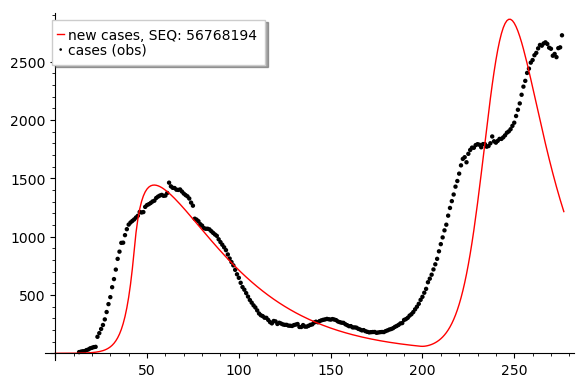

In [326]:
# <!!> célula demorada <!!>
# Estima os parâmetros pelo RandomSearch
i = 0

for trial in study:
    
    # A cada 10 iteções vai mostrar quantas iterações foram feitas
    if (i % 10 == 0):
        print(f"{i} ", end="")
    i += 1
    
    t0 = trial.parameters['t0']
    pars = [trial.parameters[n] for n in PARAM]

    O.ode_solve([0, t0+LEN], inits, num_points=t0+LEN, params=pars)
    sim = get_sim_array(O.solution)
    
    H = sim[t0 : t0 + LEN, 2] * CA_POP
    M = sim[t0 : t0 + LEN, 4] * CA_POP
        
    phi = trial.parameters["phi"]
    mu = trial.parameters["mu"]
    
    loss = sum((dfCA.cases-phi*H)**2) #+ sum((dfCA.deaths-mu*M)**2)
    
    study.add_observation(trial=trial, objective=loss)
    study.finalize(trial)

# Limpa a tela e mostra o resultado
clear_output(wait=True)    
res = study.get_best_result()
print(res)
plot_results(res)